In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from dotenv import load_dotenv
import os

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

True

In [15]:
import mlflow
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
#from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [16]:
# Obtener la URI de seguimiento de MLflow
mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")

if not mlflow_tracking_uri:
    # Preguntar al usuario por la dirección si no se encuentra la variable de entorno
    mlflow_tracking_uri = input("Ingrese la dirección de MLflow: ")

# Configurar la URI de seguimiento de MLflow
mlflow.set_tracking_uri(mlflow_tracking_uri)

experiment_name = "Regresion_Lineal_kfolds"
experiment_id = mlflow.create_experiment(experiment_name) if not mlflow.get_experiment_by_name(experiment_name) else mlflow.get_experiment_by_name(experiment_name).experiment_id

In [17]:
try:
    # Intentar leer el archivo localmente
    data = pd.read_csv('../data/Steel_industry_data.csv')
except FileNotFoundError:
    # Si no se encuentra, leer desde la URL
    data = pd.read_csv('https://raw.githubusercontent.com/luis-huacho/INF648-Proy-Curso-2024-01/main/data/Steel_industry_data.csv')

# Seleccionar las columnas para la regresión
features = data.drop(columns=['date', 'Usage_kWh'])
target = data['Usage_kWh']

In [18]:
# Define K-Folds cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

In [19]:
with mlflow.start_run(experiment_id=experiment_id):
    fold = 1
    
    # Codificación de variables categóricas
    categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']
    numerical_features = features.drop(columns=categorical_features).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )
    
    # Crear el modelo de regresión lineal
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])    
    
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        print(f'Fold {fold} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}')
        fold += 1
    
    # Log average metrics
    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    
    mlflow.log_metric("avg_mse", avg_mse)
    mlflow.log_metric("avg_rmse", avg_rmse)
    mlflow.log_metric("avg_mae", avg_mae)
    mlflow.log_metric("avg_r2", avg_r2)

    print(f'Average MSE: {avg_mse}')
    print(f'Average RMSE: {avg_rmse}')
    print(f'Average MAE: {avg_mae}')
    print(f'Average R^2: {avg_r2}')
    
    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(model, "model")
    

Fold 1 - MSE: 16.699073155321486, RMSE: 4.086449945285208, MAE: 2.487211388016378, R^2: 0.984983701232431
Fold 2 - MSE: 18.833468377574235, RMSE: 4.339754414431102, MAE: 2.551191325777752, R^2: 0.9837753118536117
Fold 3 - MSE: 17.18133229032909, RMSE: 4.145037067425223, MAE: 2.516997518070979, R^2: 0.9842889174634526
Fold 4 - MSE: 17.06693528455332, RMSE: 4.13121474684545, MAE: 2.5212179389262293, R^2: 0.9839989105302397
Fold 5 - MSE: 19.656645695598208, RMSE: 4.4335815877908695, MAE: 2.490021189595309, R^2: 0.9823200781448927
Fold 6 - MSE: 24.87656308095128, RMSE: 4.987641033690304, MAE: 2.570114742360749, R^2: 0.9771397537741978
Fold 7 - MSE: 20.13255193703475, RMSE: 4.486931238277978, MAE: 2.588438843931701, R^2: 0.9823490777124343
Fold 8 - MSE: 26.295006798571883, RMSE: 5.127865715731242, MAE: 2.5366558538922894, R^2: 0.9767474364869506
Fold 9 - MSE: 24.38545978854658, RMSE: 4.938163604878496, MAE: 2.6441980188062457, R^2: 0.978629304338117
Fold 10 - MSE: 34.51590705999244, RMSE: 5

In [20]:
# Obtener los coeficientes y el intercepto del modelo escalado
coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

In [21]:
# Obtener los nombres de las características después del procesamiento
feature_names = numerical_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
print(feature_names)

['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus_Weekday', 'WeekStatus_Weekend', 'Day_of_week_Friday', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Load_Type_Light_Load', 'Load_Type_Maximum_Load', 'Load_Type_Medium_Load']


In [22]:
df = pd.DataFrame(list(zip(feature_names, coefficients)), columns=['Feature', 'Coefficient'])
df 

,Feature,Coefficient
0,Lagging_Current_Reactive.Power_kVarh,4.674904
1,Leading_Current_Reactive_Power_kVarh,0.535364
2,CO2(tCO2),27.341795
3,Lagging_Current_Power_Factor,2.034907
4,Leading_Current_Power_Factor,1.660270
5,NSM,-0.072886
6,WeekStatus_Weekday,0.000508
7,WeekStatus_Weekend,-0.000508
8,Day_of_week_Friday,-0.106823
9,Day_of_week_Monday,-0.090720


In [23]:
# Imprimir la ecuación lineal
equation = f'y = {intercept:.2f} ' # Intercepto
for coef, name in zip(coefficients, feature_names):
    equation += f'+ ({coef:.2f} * {name}) '

print("Ecuación lineal del modelo:")
print(equation)

Ecuación lineal del modelo:
y = 27.57 + (4.67 * Lagging_Current_Reactive.Power_kVarh) + (0.54 * Leading_Current_Reactive_Power_kVarh) + (27.34 * CO2(tCO2)) + (2.03 * Lagging_Current_Power_Factor) + (1.66 * Leading_Current_Power_Factor) + (-0.07 * NSM) + (0.00 * WeekStatus_Weekday) + (-0.00 * WeekStatus_Weekend) + (-0.11 * Day_of_week_Friday) + (-0.09 * Day_of_week_Monday) + (-0.12 * Day_of_week_Saturday) + (0.12 * Day_of_week_Sunday) + (-0.22 * Day_of_week_Thursday) + (0.46 * Day_of_week_Tuesday) + (-0.04 * Day_of_week_Wednesday) + (-0.95 * Load_Type_Light_Load) + (0.29 * Load_Type_Maximum_Load) + (0.65 * Load_Type_Medium_Load) 


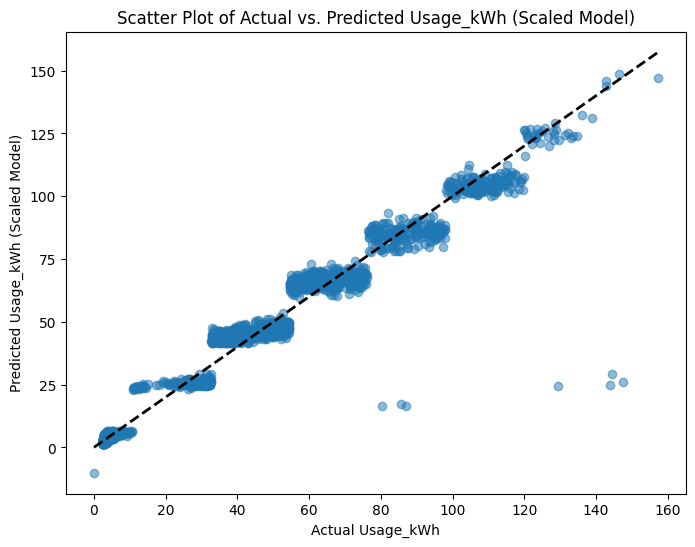

In [24]:
# Crear un gráfico de dispersión de las predicciones con el modelo escalado
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Usage_kWh')
plt.ylabel('Predicted Usage_kWh (Scaled Model)')
plt.title('Scatter Plot of Actual vs. Predicted Usage_kWh (Scaled Model)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()
